In [2]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys
import logging

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions
from rdkit import RDLogger

# Disable RDKit logging
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

dask.config.set({"dataframe.convert-string": False})
ProgressBar().register()


from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [4]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rxn_id            15999 non-null  int64  
 1   acid_smi          15999 non-null  object 
 2   amine_smi         15999 non-null  object 
 3   product_smi       15999 non-null  object 
 4   activators_names  9719 non-null   object 
 5   yield             15999 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 750.1+ KB


In [10]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

# Filter by Heavy atom count

<Axes: xlabel='ha_count', ylabel='Count'>

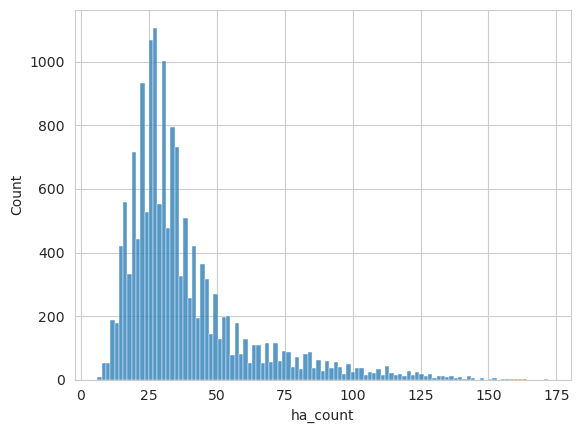

In [6]:
import seaborn as sns

def ha_count(smi: str):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetNumHeavyAtoms() if mol else None


ha = df.rxn_smi.str.split('>>').apply(lambda x: x[1]).apply(ha_count)
ha.name = 'ha_count'


sns.histplot(ha)

<Axes: xlabel='ha_count', ylabel='Count'>

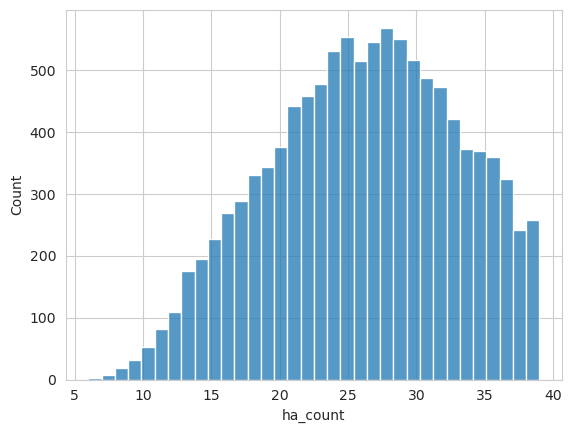

In [12]:
df = df[ha < 40].copy()

# Reactom atom-to-atom mapping

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


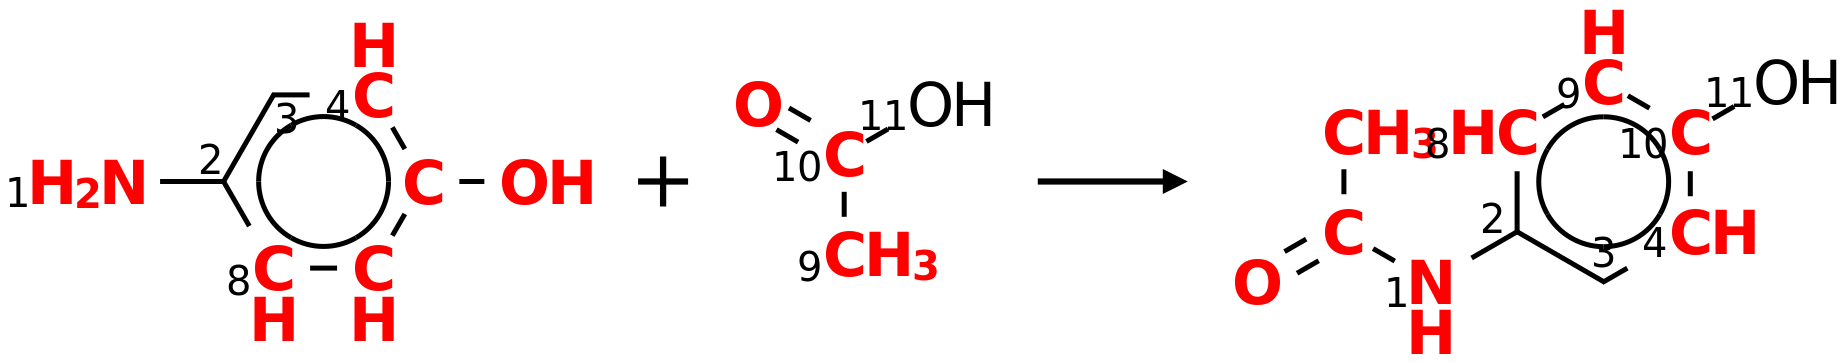

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [8]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

[CH3:1][CH2:2][NH:3][CH2:4][CH2:5][CH:6]1[CH:11]2[C:12]([CH3:14])([CH3:13])[CH:9]([CH2:10]2)[CH2:8][CH2:7]1.[CH3:15][CH2:16][C:17](O)=[O:18]>>[CH3:15][CH2:16][C:17]([N:3]([CH2:4][CH2:5][CH:6]1[CH:11]2[C:12]([CH3:13])([CH3:14])[CH:9]([CH2:10]2)[CH2:8][CH2:7]1)[CH2:2][CH3:1])=[O:18]
Reacting Atom Idx: ((2,), (2, 3))
Mapped reacting atom: N 3
Mapped reacting atom: C 17
Mapped reacting atom: O 0


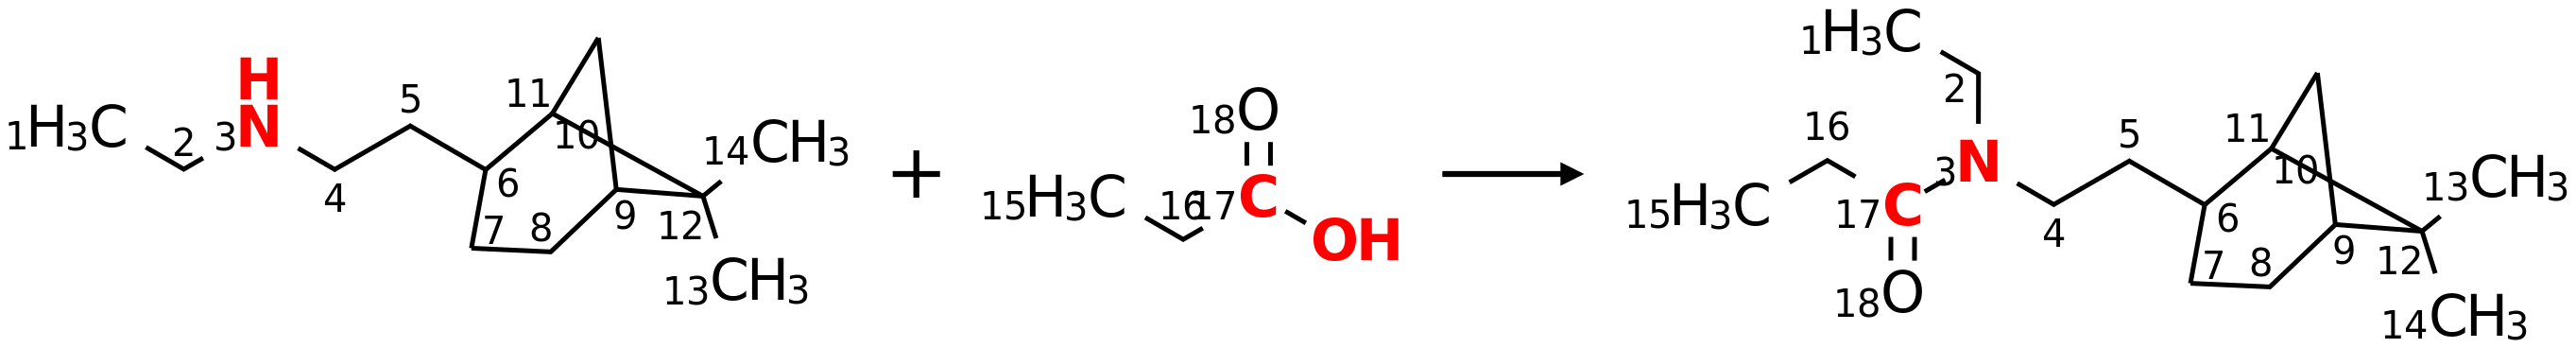

[3, 17, 0]

In [36]:
import re

re.sub(r':\d+','',  rxn_smi)

In [10]:
from linux_qm.src.util import ind_rxn_map

# def ind_rxn_map(rxn_smi):
#     try:
#         ind_rxn = indigo.loadReaction(rxn_smi)
#         ind_rxn.automap("discard")
#         return ind_rxn.smiles()
#     except:
#         return None

# def rxn_map(rxn_smi):
#     clear_smi = re.sub(r':\d+','',  rxn_smi)
#     mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
#     return mapped_rxn

In [11]:
# rxn_arr = df.rxn_smi.sample(100)
#
# %timeit list(rxn_mapper.map_reactions(rxn_arr))
# %timeit rxn_arr.apply(ind_rxn_map)
# rxn_mapper.get_attention_guided_atom_maps_for_reactions([rxn_smi])

In [12]:
df.rxn_smi = df.rxn_smi.str.replace(r':\d+','', regex=True)

In [13]:
dds = dd.from_pandas(df.rxn_smi, npartitions=128)

df.rxn_smi = dds.apply(ind_rxn_map, meta=dds).compute(scheduler='threads')

# df.rxn_smi = df.rxn_smi.apply(ind_rxn_map)

[########################################] | 100% Completed | 11.05 s


In [14]:
df.dropna(subset=['rxn_smi'], inplace=True)
df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...
3,371496,OC(CC(OC)OC)=O,NCCN,[CH3:1][O:2][CH:3]([O:19][CH3:20])[CH2:4][C:5]...,NaN,65.0,[NH2:1][CH2:2][CH2:3][NH2:4].[OH:5][C:6](=[O:1...
4,371499,OC(CC(OC)OC)=O,NCc1cccc(CN)c1,[CH3:1][O:2][CH:3]([O:25][CH3:26])[CH2:4][C:5]...,NaN,63.0,[NH2:1][CH2:2][c:3]1[cH:10][c:7]([CH2:8][NH2:9...
5,375178,OC(=O)[C@@H]1C[C@H]1c1cc[n]cc1,CNC,[CH3:1][N:2]([C:4]([C@H:6]1[C@H:8]([c:9]2[cH:1...,NaN,32.0,[CH3:1][NH:2][CH3:3].O[C:5]([C@H:7]1[C@H:9]([c...
8,380793,C(=O)CC(O)=O,NCCNCc1ccccc1,[O:1]=[C:2]([NH:17][CH2:18][CH2:19][NH:20][CH2...,NaN,69.0,[NH2:1][CH2:2][CH2:3][NH:4][CH2:5][c:6]1[cH:11...
...,...,...,...,...,...,...,...
15994,34657822,OC(=O)CC=O,CCO[Si](CCCN)(OCC)OCC,[CH3:1][CH2:2][O:3][Si:4]([O:31][CH2:32][CH3:3...,NaN,89.0,[CH3:1][CH2:2][O:3][Si:4]([O:12][CH2:13][CH3:1...
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...


[NH2:1][C@H:2]([C:8]([O:10][C:11]([CH3:14])([CH3:13])[CH3:12])=[O:9])[CH2:3][CH2:4][C:5]([OH:7])=[O:6].O[C:16](=[O:32])[CH2:17][CH2:18][CH2:19][CH2:20][CH2:21][CH2:22][CH2:23][CH2:24][CH2:25][CH2:26][CH2:27][CH2:28][CH2:29][CH2:30][CH3:31]>>[CH3:31][CH2:30][CH2:29][CH2:28][CH2:27][CH2:26][CH2:25][CH2:24][CH2:23][CH2:22][CH2:21][CH2:20][CH2:19][CH2:18][CH2:17][C:16](=[O:32])[NH:1][C@@H:2]([CH2:3][CH2:4][C:5](=[O:6])[OH:7])[C:8](=[O:9])[O:10][C:11]([CH3:14])([CH3:13])[CH3:12]
((0,), (0, 1))
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 16


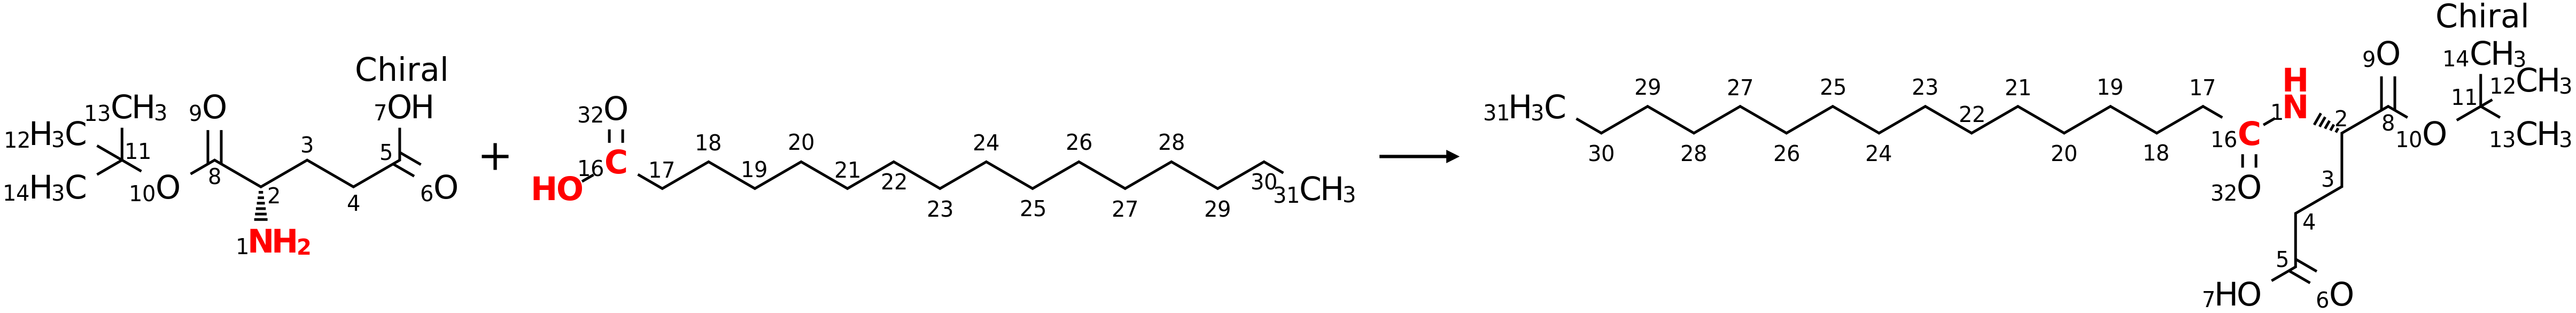

[1, 0, 16]

In [15]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)

rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()
print(rxn.GetReactingAtoms())
draw_reacting_mapnums(rxn_smi)

# Filter by amine and acid mapping


In [16]:
from linux_qm.src.util import check_amide_mapping

True
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 9


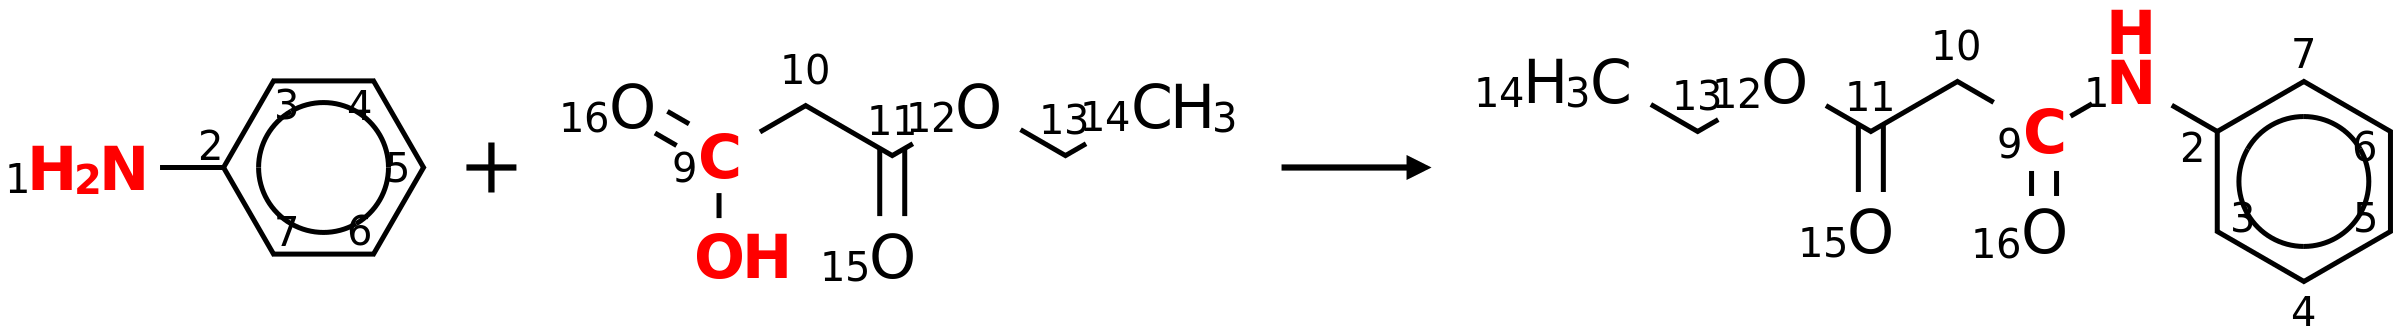

[1, 0, 9]

In [17]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(check_amide_mapping(rxn_smi))
draw_reacting_mapnums(rxn_smi)

In [18]:
# %timeit df.rxn_smi.sample(100).apply(check_amide_mapping)

In [19]:
rxn_ok = df.rxn_smi.apply(check_amide_mapping)

In [20]:
(~rxn_ok).sum()

1225

Reacting Atom Idx: ((0,), (0, 2, 4))
Mapped reacting atom: N 1
Mapped reacting atom: C 10
Mapped reacting atom: C 13
Mapped reacting atom: O 0


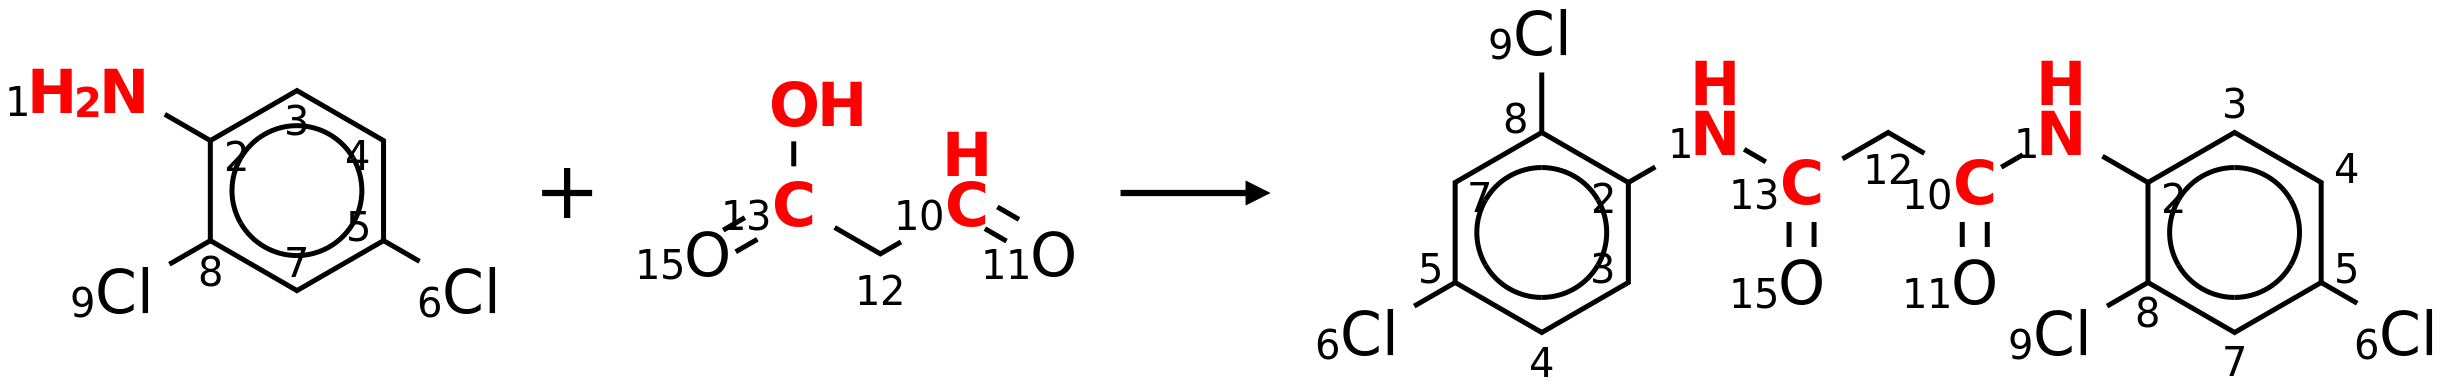

[1, 10, 13, 0]

In [21]:
draw_reacting_mapnums(df[~rxn_ok].rxn_smi.sample(1).iat[0])

Reacting Atom Idx: ((2,), (0, 1))
Mapped reacting atom: N 3
Mapped reacting atom: O 0
Mapped reacting atom: C 6


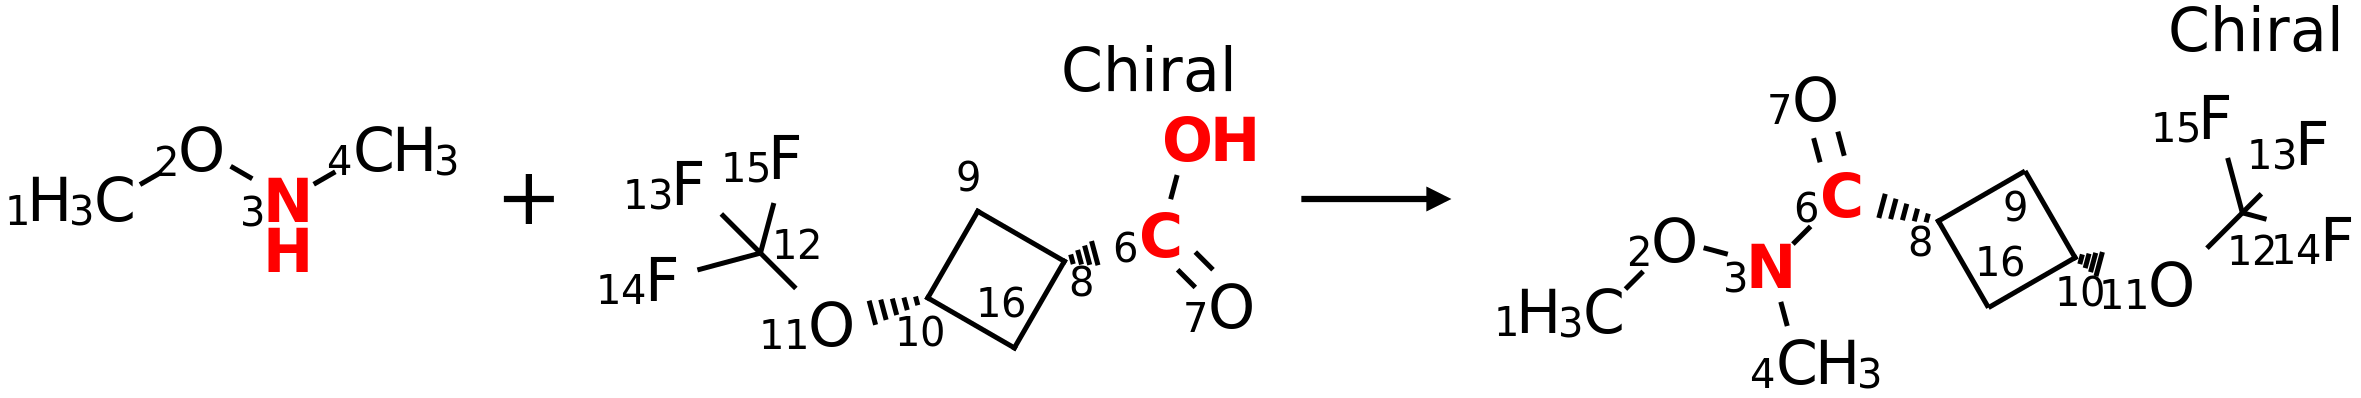

In [22]:
try:
    draw_reacting_mapnums(df[~rxn_ok].rxn_smi.sample(1).iat[0])
except:
    pass

In [23]:
df = df[rxn_ok].copy()
df.shape

(9491, 7)

In [24]:
df.to_csv('../data/slv_amides/amide_mapped_training_set.csv', index=False)

# ORCA amine calculation

In [25]:
from linux_qm.desc.electronic import orca_calculation, get_amine_electronic
from linux_qm.src.util import load_smiles3D

In [26]:
mol = load_smiles3D("NCF", opt=True)

# qm calculation
data = orca_calculation(mol.GetConformer())
data.atomcharges

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            0.87722859         -0.03418677          0.31683889
C           -0.53054457         -0.20677225          0.04504673
F           -0.83696990          0.65634490         -0.95130995
H            1.36606231         -0.18002211         -0.56515469
H            1.01676189          0.95355964          0.52426469
H           -0.75250324         -1.22328525         -0.28916960
H           -1.14003507          0.03436184          0.91948393
*


DEBUG:root:ORCA OUTPUT:

                                *** OPTIMIZATION RUN DONE ***

Timings for individual modules:

Sum of individual times         ...        0.146 sec (=   0.002 min)
Geometry relaxation             ...        0.066 sec (=   0.001 min)  45.5 %
XTB module                      ...        0.079 sec (=   0.001 min)  54.5 %
                             ****ORCA TERMINATED NORMALLY****
TOTAL RUN TIME: 0 days 0 hours 0 minute

{'mulliken': array([-0.513857,  0.101898, -0.342836,  0.22891 ,  0.22891 ,  0.148487,
         0.148487]),
 'lowdin': array([-0.338694,  0.130861, -0.284276,  0.158811,  0.158811,  0.087244,
         0.087244])}

In [27]:
get_amine_electronic("Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O", automap=True)

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            2.30646039          0.17338486         -0.48186793
C            0.95591493          0.04176966         -0.14357463
C            0.20839936         -1.03167379         -0.63710034
C           -1.16818035         -1.10978421         -0.40558545
C           -1.81032835         -0.08734729          0.28728565
Cl          -3.50452138         -0.17720024          0.57126784
C           -1.08989036          1.01671284          0.73430346
C            0.28642115          1.08754642          0.49888713
H            2.83285496          0.77601772          0.14303986
H            2.77817279         -0.70918726         -0.65310326
H            0.69299527         -1.81936989         -1.20809100
H           -1.73017286         -1.96059060         -0.78018619
H           -1.59061534          1.83007000          1.25175699
H            0.83248978          1.96965177          0.82296787
*

array([-0.497356,  0.114101, -0.306927,  0.103188, -8.119306,  4.78534 ])

In [44]:
import logging
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.DEBUG)

def plot_electronic_descriptor(reactions, labels):


    amine_descr = np.empty((0, 6))
    for rxn_smi in reactions:
        d = get_amine_electronic(rxn_smi, automap=True)
        amine_descr = np.vstack([amine_descr, d])

    res = pd.DataFrame(amine_descr,
                       # columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'npa_N', 'npa_C', 'HOMO', 'LUMO'],
                       columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'HOMO', 'LUMO'],
                       index=labels)

    scaler = StandardScaler()

    res.iloc[:] = scaler.fit_transform(res)
    fig, ax = plt.subplots(1,3)

    fig.set_size_inches(12, 4)

    sns.lineplot(
        # res[['mul_N', 'low_N', 'npa_N']]
        res[['mul_N', 'low_N']],
        # palette=['red', 'blue'],
        ax=ax[0]
    )
    sns.lineplot(
        # res[['mul_C', 'low_C', 'npa_C']]
        res[['mul_C', 'low_C']],
        ax=ax[1]
    )
    sns.lineplot(
        # res[['mul_C', 'low_C', 'npa_C']]
        res[['HOMO', 'LUMO']],
        ax=ax[2]
    )

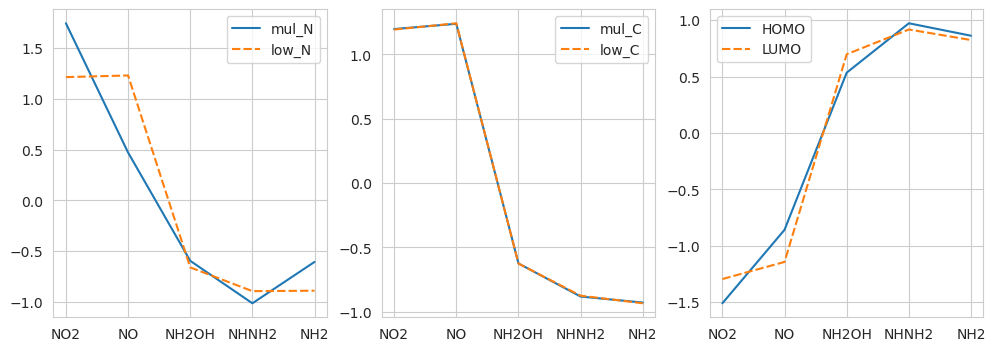

In [50]:
reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",

    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    # "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",

    "Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O",
    "Nc1ccc(N=O)cc1.CC(O)=O>>CC(Nc1ccc(N=O)cc1)=O",
    "Nc1ccc(NO)cc1.CC(O)=O>>CC(Nc1ccc(NO)cc1)=O",
    "Nc1ccc(NN)cc1.CC(O)=O>>CC(Nc1ccc(NN)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",


    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    # "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    # "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
# labels = ['NH2', 'NHMe', 'NMe2']
# labels = ['F', 'Cl', 'Br', 'I']

labels = ['NO2','NO', 'NH2OH', 'NHNH2', 'NH2']
plot_electronic_descriptor(reactions, labels)

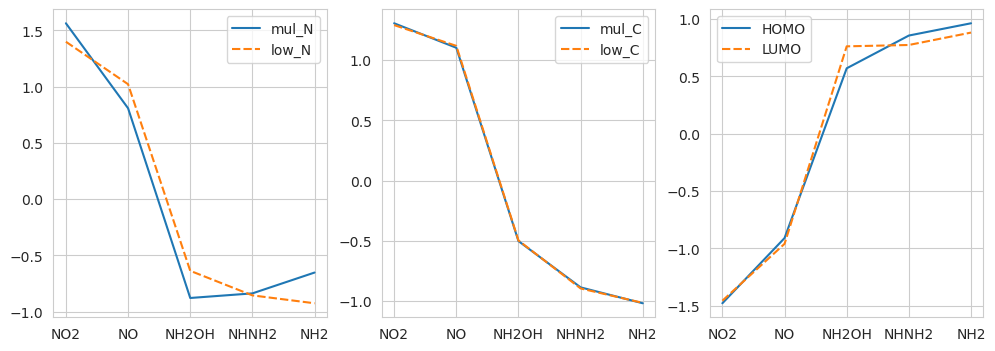

In [51]:
# HF-3c GEOM OPT
plot_electronic_descriptor(reactions, labels)

In [ ]:
# BP86 def2-SVP GEOM OPT
plot_electronic_descriptor(reactions, labels)

In [49]:
logging.getLogger().setLevel(logging.WARNING)

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -2.94922233         -0.60321942          0.13427440
C           -1.59398808         -0.26747762          0.03014386
C           -0.98513268          0.51776260          1.01083530
C            0.39148584          0.76250872          0.97938403
C            1.19224931          0.17889624         -0.00720757
C            2.66335924          0.46330233         -0.06223632
C            0.59099048         -0.64535261         -0.96339278
C           -0.78623563         -0.88581202         -0.92602596
H           -3.50589355          0.09570854          0.61554888
H           -3.36614597         -0.89046013         -0.74531388
H           -1.57913691          0.95202350          1.81023235
H            0.83391824          1.40033316          1.74085193
H            3.21060987         -0.38724732         -0.48212788
H            2.85071583          1.34538877         -0.68218121
H

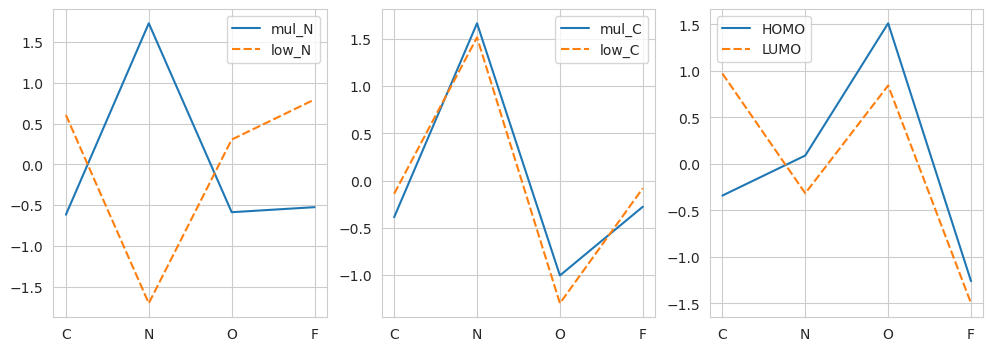

In [46]:
reactions = [
    "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
]
labels = ['C', 'N', 'O', 'F']

plot_electronic_descriptor(reactions, labels)

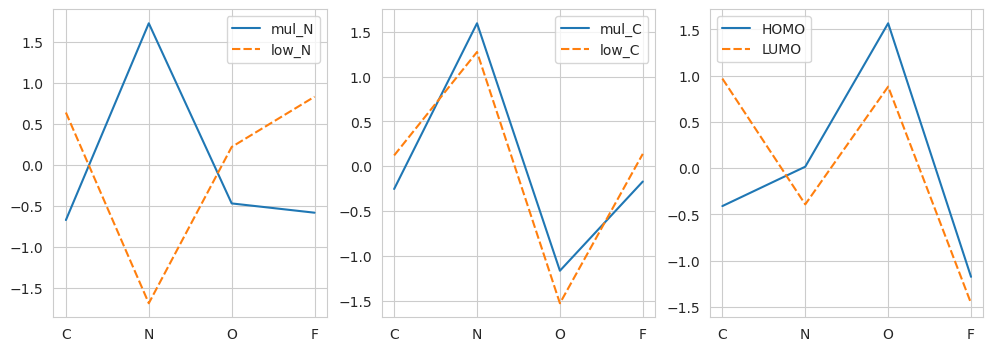

In [52]:
# HF-3c GEOM OPT
reactions = [
    "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
]
labels = ['C', 'N', 'O', 'F']
plot_electronic_descriptor(reactions, labels)

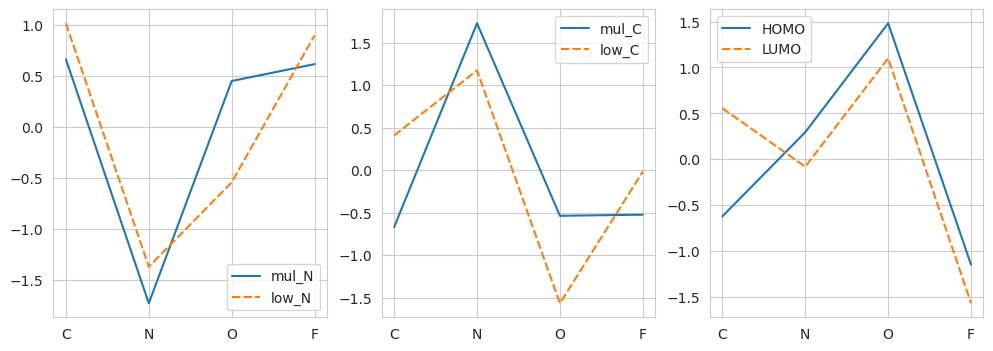

In [54]:
# BP86 def2-SVP GEOM OPT
reactions = [
    "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
]
labels = ['C', 'N', 'O', 'F']
plot_electronic_descriptor(reactions, labels)

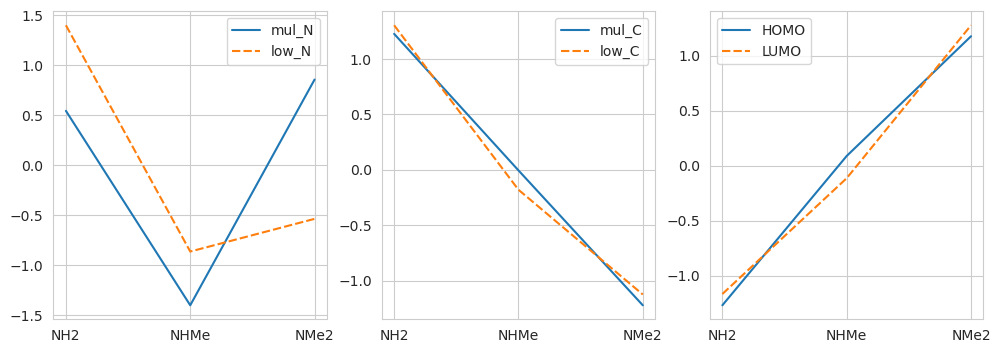

In [55]:
# HF-3c single point
reactions = [
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",

]
labels = ['NH2', 'NHMe', 'NMe2']
plot_electronic_descriptor(reactions, labels)

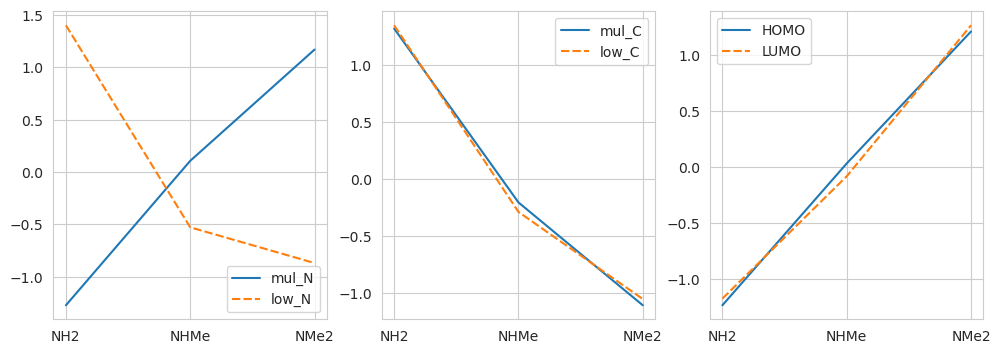

In [56]:
# HF-3c geom opt
plot_electronic_descriptor(reactions, labels)

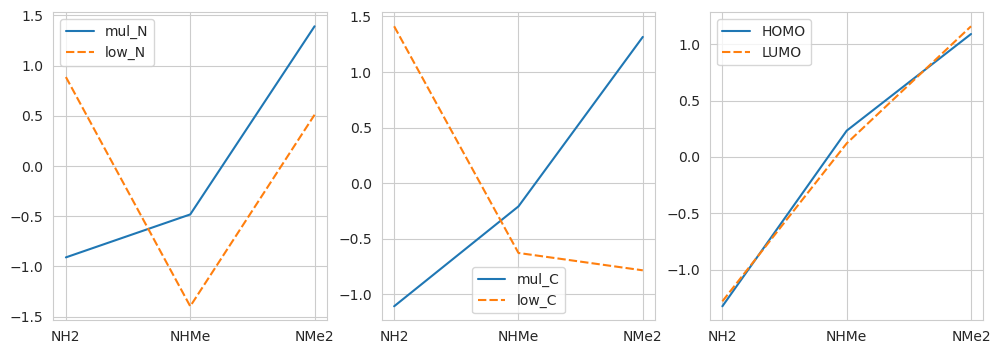

In [57]:
# BP86 def2-SVP GEOM OPT
plot_electronic_descriptor(reactions, labels)

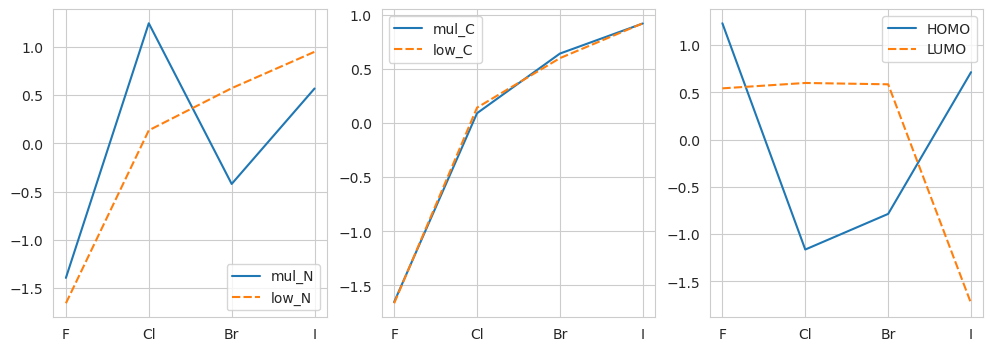

In [58]:
reactions = [
    "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

labels = ['F', 'Cl', 'Br', 'I']
plot_electronic_descriptor(reactions, labels)

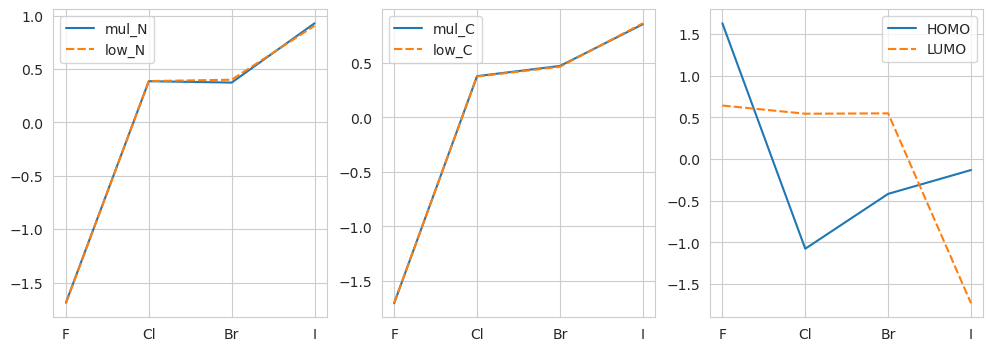

In [59]:
# HF-3c geom opt
plot_electronic_descriptor(reactions, labels)

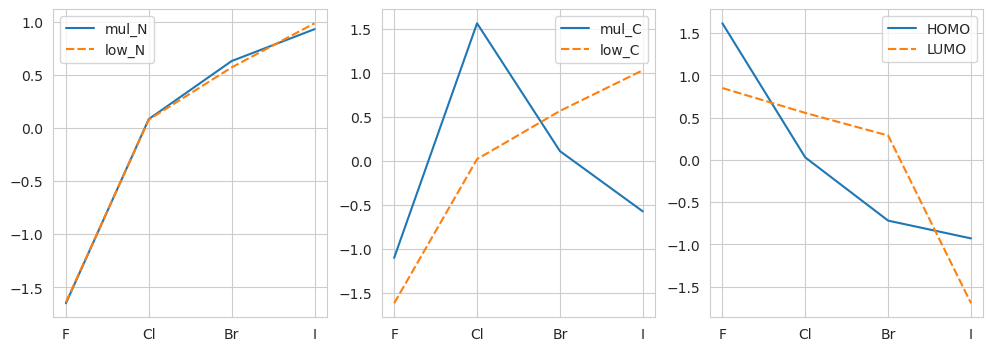

In [60]:
# BP86 def2-SVP GEOM OPT
plot_electronic_descriptor(reactions, labels)

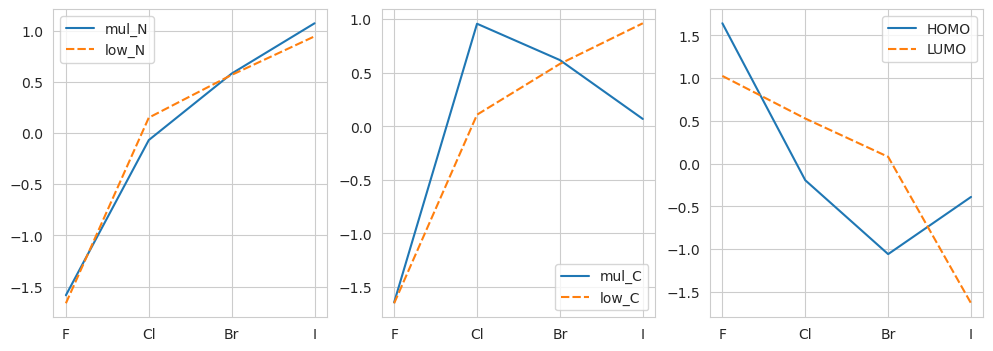

In [61]:
# BP86 def2-TZVP GEOM OPT
plot_electronic_descriptor(reactions, labels)

In [39]:
get_amine_electronic("Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O")

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -2.77851346          0.35566501         -0.38604971
C           -1.41940255          0.10906186         -0.17317516
C           -0.82212392          0.46785817          1.03981015
C            0.55835481          0.34197815          1.22497072
C            1.35517422         -0.10938331          0.16707886
N            2.80535393         -0.24160068          0.35089015
O            3.47547092         -0.63838456         -0.61340694
O            3.27516202          0.04808114          1.46072368
C            0.78005172         -0.41779348         -1.07062099
C           -0.60218441         -0.28589302         -1.23758778
H           -3.34441433          0.33739563          0.45695164
H           -3.19049686         -0.19009618         -1.13681287
H           -1.43103392          0.85127486          1.85540896
H            0.99050952          0.61160302          2.18612199
H

array([-0.497085,  0.144528, -0.295287,  0.137258, -8.844353,  2.542523])

In [40]:
import logging
logging.getLogger().setLevel(logging.WARNING)

df.rxn_smi.sample(1).apply(get_amine_electronic)

10926    [-0.405026, -0.141857, -0.139457, -0.270917, -...
Name: rxn_smi, dtype: object

In [41]:
from linux_qm.desc.electronic import get_amine_atoms

def check_amine_atoms(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)
    return get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])

amine_atoms = df.rxn_smi.apply(check_amine_atoms)
amine_atoms.apply(len).value_counts(dropna=False)

rxn_smi
2    7948
3    1543
Name: count, dtype: int64

# Acid electronic descriptor

In [42]:
def get_acid_atoms(mol, react_acid_ids: list):
    # Order should be
    # [C, =O, -OH, C bounded to C=O]
    result = []
    for i in react_acid_ids:
        if mol.GetAtomWithIdx(i).GetSymbol() == 'C':
            result.append(i)
    for i in react_acid_ids:
        atom = mol.GetAtomWithIdx(i)
        if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 1:
            result.append(i)
    for i in react_acid_ids:
        atom = mol.GetAtomWithIdx(i)
        if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 0:
            result.append(i)

    atom = mol.GetAtomWithIdx(result[0])
    for nei in atom.GetNeighbors():
        if nei.GetSymbol() == 'C':
            result.append(nei.GetIdx())

    return result

In [43]:
def get_acid_electronic(rxn_smi):
    # try:
    # try rxn_mapper:
    rxn_smi = ind_rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)

    acid_atoms = get_acid_atoms(acid, rxn.GetReactingAtoms()[1])
    logging.debug(f'Acid atom ids: {acid_atoms}')

    logging.info(f"Heavy Atom Count: {acid.GetNumHeavyAtoms()}")

    mol = load_smiles3D(Chem.MolToSmiles(acid), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    charges = np.hstack([
        data.atomcharges['mulliken'][acid_atoms],
        data.atomcharges['lowdin'][acid_atoms],
        # data.atomcharges['npa'][amine_raids],
    ])
    homo = data.moenergies[0][data.homos[0]]
    lumo = data.moenergies[0][data.homos[0] + 1]

    return np.hstack([charges, homo, lumo]).round(6)

    # except Exception as e:
    #     logging.warning(f"{type(e).__name__}: {e} for rxn_smi: {rxn_smi}")
    #     return None

In [44]:
def check_acid_atoms(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)
    return get_acid_atoms(acid, rxn.GetReactingAtoms()[1])

# rxn_smi = df.rxn_smi.sample(1).iat[0]
# ge

acid_atoms = df.rxn_smi.apply(check_acid_atoms)

In [45]:
acid_atoms.apply(len).value_counts(dropna=False)

rxn_smi
3    9491
Name: count, dtype: int64

Reacting Atom Idx: ((5,), (0, 1))
Mapped reacting atom: N 7
Mapped reacting atom: O 0
Mapped reacting atom: C 9


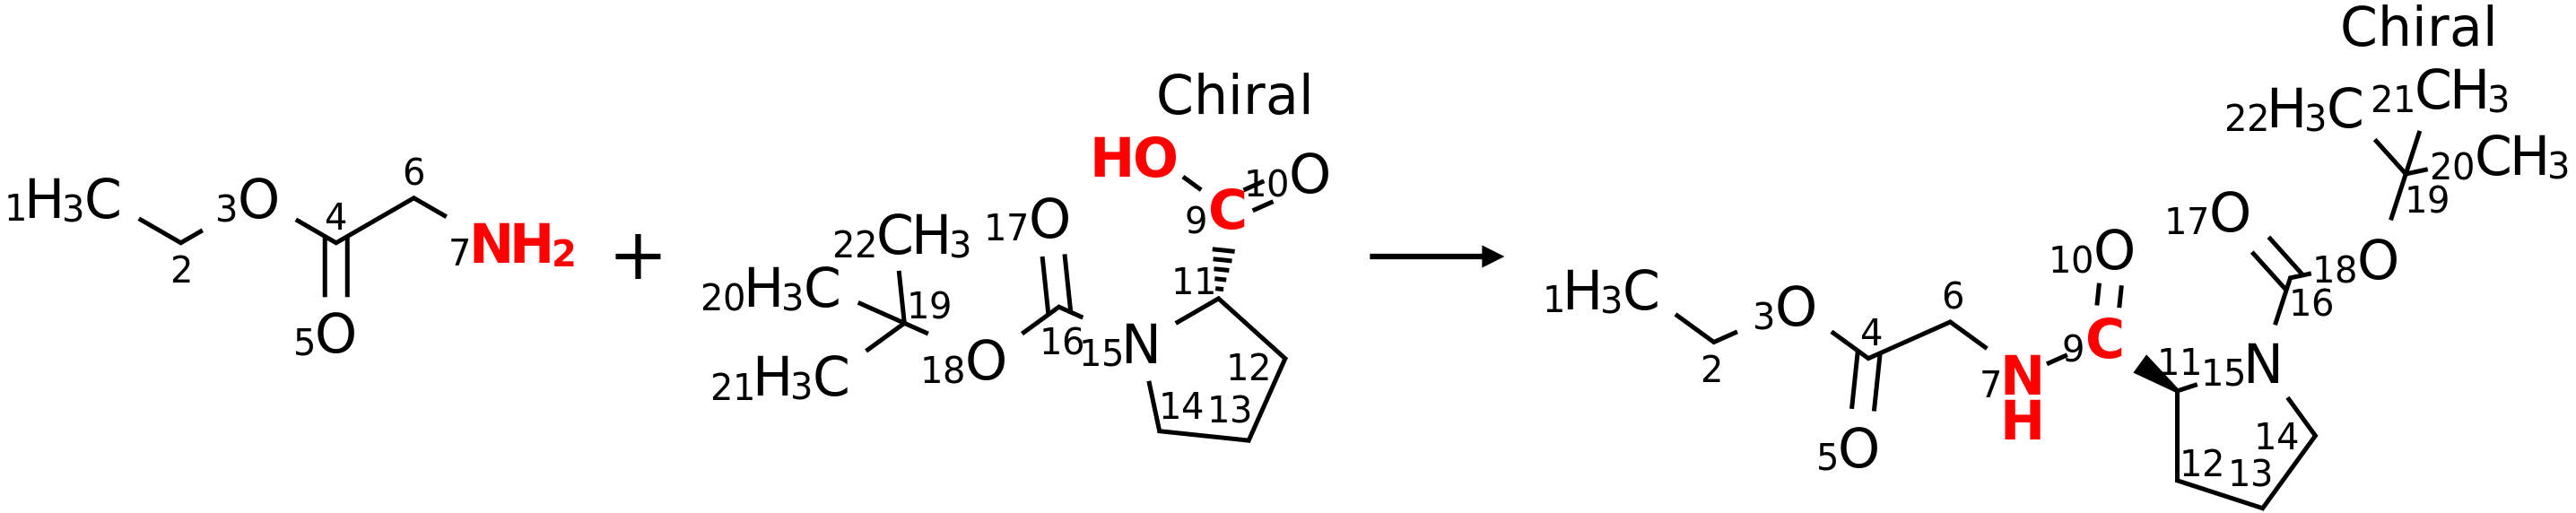

array([ 0.503725, -0.502044, -0.325011,  0.369718, -0.346304, -0.194664,
       -9.655225,  5.986967])

In [46]:
rxn_smi = df.rxn_smi.sample(1).iat[0]

draw_reacting_mapnums(rxn_smi)

get_acid_electronic(rxn_smi)

# Timings

INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 15
INFO:root:Elapsed Time: 5.7s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True


CCCCCCCCCCCCNC(=O)[C@H](CCCNC(=N)N)N
Elapsed Time: 12.22s
Reacting Atom Idx: ((15,), (0, 1))
Mapped reacting atom: N 24
Mapped reacting atom: O 0
Mapped reacting atom: C 26


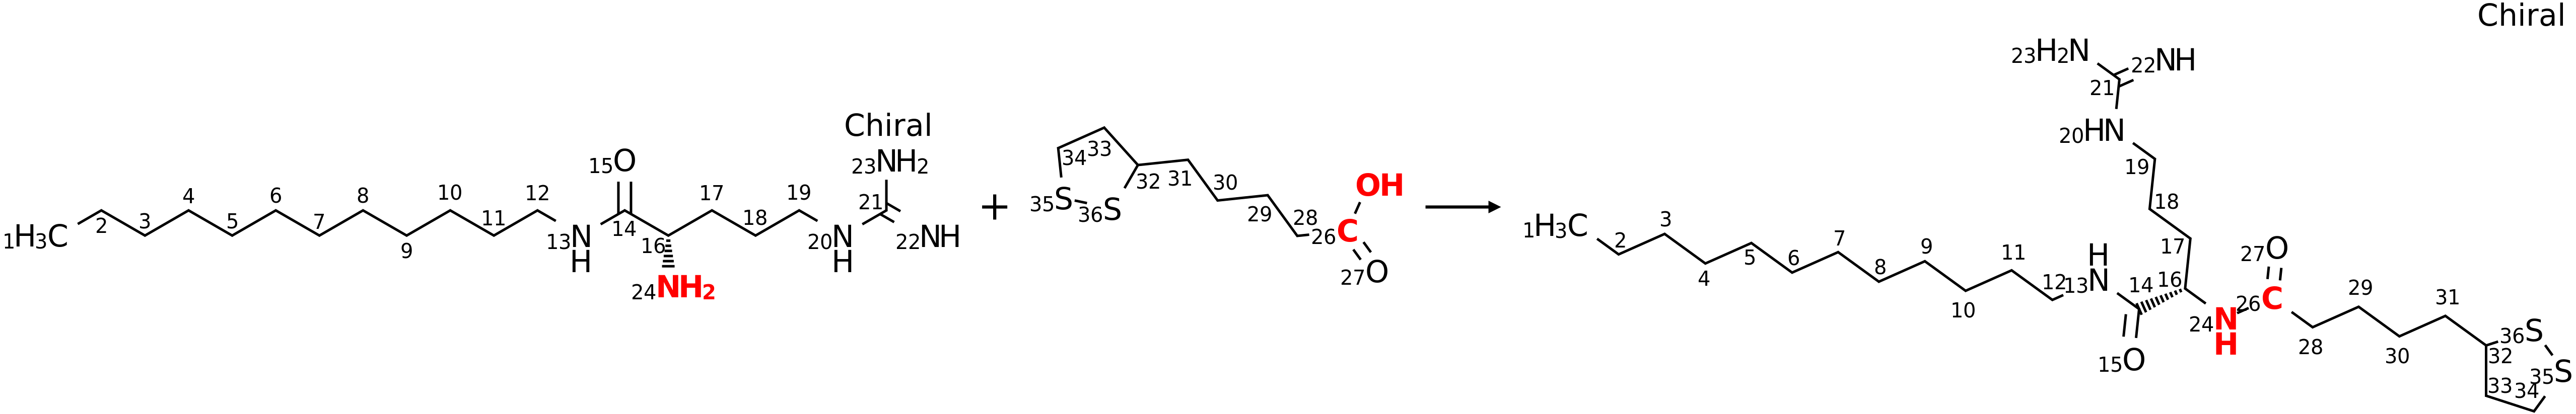

INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 17
INFO:root:Elapsed Time: 2.4s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True


Nc1[n]c(OCc2ccc(CN)cc2)c2[nH]c[n]c2[n]1
Elapsed Time: 5.59s
Reacting Atom Idx: ((16,), (0, 1))
Mapped reacting atom: N 12
Mapped reacting atom: O 0
Mapped reacting atom: C 22


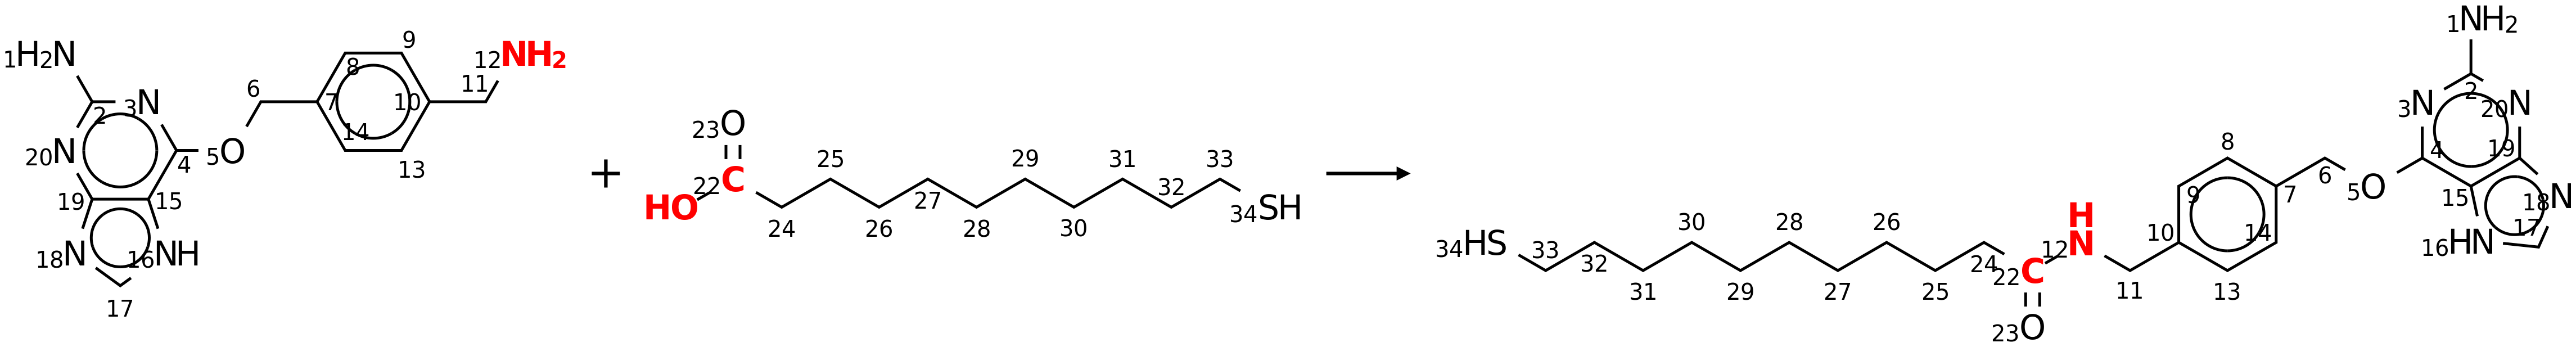

INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 11
INFO:root:Elapsed Time: 0.8s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 9
INFO:root:Elapsed Time: 1.0s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 12
INFO:root:Elapsed Time: 1.0s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 9
INFO:root:Elapsed Time: 0.5s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:r

In [47]:
import logging

logging.getLogger().setLevel(logging.INFO)

from time import time
for i, row in df.sample(10).iterrows():  
    start = time()
    rxn_smi = row['rxn_smi']
    get_amine_electronic(rxn_smi)
    time_elapsed = time() - start
    if time_elapsed > 5:
        print(row['amine_smi'])
        print(f'Elapsed Time: {time_elapsed:.2f}s')
        draw_reacting_mapnums(rxn_smi)

# Dask parallel run

In [138]:
dds = dd.from_pandas(df.rxn_smi[:512], npartitions=32)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 501.82 s
[########################################] | 100% Completed | 501.92 s


In [139]:
dds = dd.from_pandas(df.rxn_smi[:512], npartitions=64)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 267.95 s
[########################################] | 100% Completed | 268.05 s


In [79]:
dds = dd.from_pandas(df.rxn_smi[:512], npartitions=64)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

112      [-0.491071, -0.164249, -0.327817, -0.102411, -...
482      [-0.142705, -0.124211, -0.074503, -0.062335, -...
581      [-0.501455, -0.138369, -0.341789, -0.068657, -...
662      [-0.16419, -0.424948, -0.103035, -0.346248, -1...
1298     [-0.497542, 0.153228, -0.295151, 0.121018, -9....
                               ...                        
14819    [-0.497841, -0.142917, -0.337943, -0.072637, -...
15663    [-0.491459, -0.147166, -0.331739, -0.075131, -...
15895    [-0.542153, 0.917343, -0.347865, 0.374374, -7....
15972    [-0.501943, -0.140956, -0.34231, -0.070309, -9...
15983    [-0.500467, -0.271562, -0.336462, -0.162912, -...
Name: amine_descriptor, Length: 128, dtype: object

In [77]:
df.rxn_smi.sample(8).apply(get_amine_electronic)

INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 14
INFO:root:Elapsed Time: 0.8s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 7
INFO:root:Elapsed Time: 0.4s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 9
INFO:root:Elapsed Time: 0.6s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Method: XTB2
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:root:Num Iter: 11
INFO:root:Elapsed Time: 0.6s
INFO:root:Method: HF-3c
INFO:cclib:Identified logfile to be in ORCA format
INFO:root:Success: True
INFO:r

11253    [-0.498106, -0.144195, -0.337791, -0.074048, -...
15238    [-0.363116, -0.016626, -0.238848, 0.019796, -9...
14644    [-0.126033, -0.362189, -0.412903, -0.064542, -...
10776    [-0.498246, 0.109131, -0.294782, 0.077237, -9....
11692    [-0.500467, -0.271562, -0.336462, -0.162912, -...
13955    [-0.167199, -0.132901, -0.136254, -0.083468, -...
7583     [-0.151957, -0.125663, -0.086845, -0.062938, -...
573      [-0.498505, -0.143556, -0.338538, -0.07564, -9...
Name: rxn_smi, dtype: object

In [51]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=8)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 243.04 s
[########################################] | 100% Completed | 243.14 s


In [52]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=16)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 154.48 s
[########################################] | 100% Completed | 154.58 s


In [53]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=32)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 77.96 s
[########################################] | 100% Completed | 78.06 s


In [54]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=64)
amine_descr = dds.apply(get_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 66.45 s
[########################################] | 100% Completed | 66.55 s


In [56]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=64)
amine_descr = dds.apply(get_amine_electronic,
                        # args=(2,),
                        n_jobs=2,
                        meta=dds).compute(scheduler='processes')

[###############                         ] | 37% Completed | 83.76 ss

[ORCA stream <class '_io.StringIO'> ERROR] Unexpectedly encountered end of logfile.
ERROR:ORCA stream <class '_io.StringIO'>:Unexpectedly encountered end of logfile.


[########################################] | 100% Completed | 109.67 s
[########################################] | 100% Completed | 109.77 s


In [57]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=64)
amine_descr = dds.apply(get_amine_electronic,
                        # args=(2,),
                        n_jobs=4,
                        meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 102.54 s
[########################################] | 100% Completed | 102.64 s


In [ ]:
for i, row in df[:16].iterrows():
    amine_descr = get_amine_electronic(row['rxn_smi'])
    print(amine_descr)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)
get_amine_electronic(df.rxn_smi.iat[2])

In [ ]:
draw_reacting_mapnums(df.rxn_smi.iat[2])

In [1]:
import pandas as pd
amine_df = pd.read_pickle('../data/slv_amides/amine_descriptor.pkl')
amine_df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi,amine_electronic_descr
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...,"[-0.50928, -0.169642, -0.342331, -0.105613, -9..."
13,429257,OC(=O)CCCN1CCC(C(C)(C)CN(C)C)CC1,CC(C)CCCN,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH:7][C:8]...,NaN,71.0,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH2:7])[CH...,"[-0.141413, -0.248151, -0.070556, -0.160602, -..."
15,447076,OC(c1cc(OC)c(OC)c(OC)c1)=O,N1CCOCC1,[CH3:1][O:2][c:3]1[c:18]([O:19][CH3:20])[c:15]...,Sodium methoxide,54.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[-0.410032, -0.155161, -0.153874, -0.277775, -..."
16,450635,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CN,[CH3:1][NH:2][C:3]([c:5]1[cH:29][n:8](-[c:9]2[...,NaN,72.0,[CH3:1][NH2:2].O[C:4]([c:6]1[cH:30][n:9](-[c:1...,"[-0.500467, -0.271562, -0.336462, -0.162912, -..."
17,450637,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CCN,[CH3:1][CH2:2][NH:3][C:4]([c:6]1[cH:30][n:9](-...,NaN,60.0,[CH3:1][CH2:2][NH2:3].O[C:5]([c:7]1[cH:31][n:1...,"[-0.497624, -0.145648, -0.338333, -0.070222, -..."
...,...,...,...,...,...,...,...,...
15988,34599083,OC([C@H](NC(OC(C)(C)C)=O)c1ccccc1)=O,N1CCCCC1,[CH3:1][C:2]([O:5][C:6]([NH:8][C@H:9]([c:18]1[...,Other,80.0,[NH:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH2:2]1.O[...,"[-0.406654, -0.1412, -0.141201, -0.27373, -0.0..."
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...,"[-0.496258, -0.136446, -0.334703, -0.063975, -..."
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[-0.410032, -0.153874, -0.155161, -0.277775, -..."
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...,"[-0.373163, -0.020249, -0.251272, 0.01747, -9...."


In [3]:
amine_df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi,amine_electronic_descr
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...,"[-0.50928, -0.169642, -0.342331, -0.105613, -9..."
13,429257,OC(=O)CCCN1CCC(C(C)(C)CN(C)C)CC1,CC(C)CCCN,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH:7][C:8]...,NaN,71.0,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH2:7])[CH...,"[-0.141413, -0.248151, -0.070556, -0.160602, -..."
15,447076,OC(c1cc(OC)c(OC)c(OC)c1)=O,N1CCOCC1,[CH3:1][O:2][c:3]1[c:18]([O:19][CH3:20])[c:15]...,Sodium methoxide,54.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[-0.410032, -0.155161, -0.153874, -0.277775, -..."
16,450635,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CN,[CH3:1][NH:2][C:3]([c:5]1[cH:29][n:8](-[c:9]2[...,NaN,72.0,[CH3:1][NH2:2].O[C:4]([c:6]1[cH:30][n:9](-[c:1...,"[-0.500467, -0.271562, -0.336462, -0.162912, -..."
17,450637,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CCN,[CH3:1][CH2:2][NH:3][C:4]([c:6]1[cH:30][n:9](-...,NaN,60.0,[CH3:1][CH2:2][NH2:3].O[C:5]([c:7]1[cH:31][n:1...,"[-0.497624, -0.145648, -0.338333, -0.070222, -..."
...,...,...,...,...,...,...,...,...
15988,34599083,OC([C@H](NC(OC(C)(C)C)=O)c1ccccc1)=O,N1CCCCC1,[CH3:1][C:2]([O:5][C:6]([NH:8][C@H:9]([c:18]1[...,Other,80.0,[NH:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH2:2]1.O[...,"[-0.406654, -0.1412, -0.141201, -0.27373, -0.0..."
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...,"[-0.496258, -0.136446, -0.334703, -0.063975, -..."
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[-0.410032, -0.153874, -0.155161, -0.277775, -..."
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...,"[-0.373163, -0.020249, -0.251272, 0.01747, -9...."


In [2]:
acid_df = pd.read_pickle('../data/slv_amides/acid_descriptor.pkl')
acid_df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi,acid_electronic_descr
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...,"[0.512687, -0.495433, -0.026595, 0.382306, -0...."
13,429257,OC(=O)CCCN1CCC(C(C)(C)CN(C)C)CC1,CC(C)CCCN,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH:7][C:8]...,NaN,71.0,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH2:7])[CH...,"[0.487214, -0.501376, -0.423982, 0.368049, -0...."
15,447076,OC(c1cc(OC)c(OC)c(OC)c1)=O,N1CCOCC1,[CH3:1][O:2][c:3]1[c:18]([O:19][CH3:20])[c:15]...,Sodium methoxide,54.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[0.484957, -0.498185, -0.154452, 0.366127, -0...."
16,450635,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CN,[CH3:1][NH:2][C:3]([c:5]1[cH:29][n:8](-[c:9]2[...,NaN,72.0,[CH3:1][NH2:2].O[C:4]([c:6]1[cH:30][n:9](-[c:1...,"[0.486708, -0.494865, -0.418344, 0.369711, -0...."
17,450637,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CCN,[CH3:1][CH2:2][NH:3][C:4]([c:6]1[cH:30][n:9](-...,NaN,60.0,[CH3:1][CH2:2][NH2:3].O[C:5]([c:7]1[cH:31][n:1...,"[0.484184, -0.499049, -0.416312, 0.36896, -0.3..."
...,...,...,...,...,...,...,...,...
15988,34599083,OC([C@H](NC(OC(C)(C)C)=O)c1ccccc1)=O,N1CCCCC1,[CH3:1][C:2]([O:5][C:6]([NH:8][C@H:9]([c:18]1[...,Other,80.0,[NH:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH2:2]1.O[...,"[0.501979, -0.493218, -0.41414, 0.370615, -0.3..."
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...,"[0.481145, -0.498518, -0.224146, 0.359481, -0...."
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[0.495927, -0.499583, -0.172703, 0.362501, -0...."
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...,"[0.500855, -0.477508, -0.407802, 0.365958, -0...."


In [4]:
df = acid_df
df['amine_electronic_descriptor'] = amine_df.amine_electronic_descr
df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi,acid_electronic_descr,amine_electronic_descriptor
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...,"[0.512687, -0.495433, -0.026595, 0.382306, -0....","[-0.50928, -0.169642, -0.342331, -0.105613, -9..."
13,429257,OC(=O)CCCN1CCC(C(C)(C)CN(C)C)CC1,CC(C)CCCN,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH:7][C:8]...,NaN,71.0,[CH3:1][CH:2]([CH2:4][CH2:5][CH2:6][NH2:7])[CH...,"[0.487214, -0.501376, -0.423982, 0.368049, -0....","[-0.141413, -0.248151, -0.070556, -0.160602, -..."
15,447076,OC(c1cc(OC)c(OC)c(OC)c1)=O,N1CCOCC1,[CH3:1][O:2][c:3]1[c:18]([O:19][CH3:20])[c:15]...,Sodium methoxide,54.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[0.484957, -0.498185, -0.154452, 0.366127, -0....","[-0.410032, -0.155161, -0.153874, -0.277775, -..."
16,450635,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CN,[CH3:1][NH:2][C:3]([c:5]1[cH:29][n:8](-[c:9]2[...,NaN,72.0,[CH3:1][NH2:2].O[C:4]([c:6]1[cH:30][n:9](-[c:1...,"[0.486708, -0.494865, -0.418344, 0.369711, -0....","[-0.500467, -0.271562, -0.336462, -0.162912, -..."
17,450637,OC(=O)c1c[n][n](-c2[n]c(NC)c3[n]c[n]([C@@H]4O[...,CCN,[CH3:1][CH2:2][NH:3][C:4]([c:6]1[cH:30][n:9](-...,NaN,60.0,[CH3:1][CH2:2][NH2:3].O[C:5]([c:7]1[cH:31][n:1...,"[0.484184, -0.499049, -0.416312, 0.36896, -0.3...","[-0.497624, -0.145648, -0.338333, -0.070222, -..."
...,...,...,...,...,...,...,...,...,...
15988,34599083,OC([C@H](NC(OC(C)(C)C)=O)c1ccccc1)=O,N1CCCCC1,[CH3:1][C:2]([O:5][C:6]([NH:8][C@H:9]([c:18]1[...,Other,80.0,[NH:1]1[CH2:6][CH2:5][CH2:4][CH2:3][CH2:2]1.O[...,"[0.501979, -0.493218, -0.41414, 0.370615, -0.3...","[-0.406654, -0.1412, -0.141201, -0.27373, -0.0..."
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...,"[0.481145, -0.498518, -0.224146, 0.359481, -0....","[-0.496258, -0.136446, -0.334703, -0.063975, -..."
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...,"[0.495927, -0.499583, -0.172703, 0.362501, -0....","[-0.410032, -0.153874, -0.155161, -0.277775, -..."
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...,"[0.500855, -0.477508, -0.407802, 0.365958, -0....","[-0.373163, -0.020249, -0.251272, 0.01747, -9...."


In [5]:
df.to_csv('../data/slv_amides/amides_train_el_descr.csv')

In [ ]:
mol = load_smiles3D('C1CCN1', num_conf=3)
print(Chem.MolToXYZBlock(mol, confId=0))